# setup and imports

In [110]:
import fnmatch
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from ipywidgets import interactive
import numpy as np
import os
import glob
from scipy.ndimage import gaussian_filter as smooth
import platform

%run sessionlists
from VIGOR_utils import *
from VIGOR_plotting import *
from VIGOR_MODELS_Functions import *

plt.style.use('./Figures/paper.mplstyle')

In [111]:
#### Define folder with data 
if platform.system()=='Linux':
    root="/home/david/Desktop/ALLDATA"
    savePath="/home/david/Desktop/Save"
elif platform.system()=='Darwin':
    root="/Users/tom/Desktop/DATA"
    savePath="/Users/tom/Desktop/Save"
if 'COLAB_GPU' in os.environ:
    !gdown --id 1BSepSzm1-KQJlUvv8C23p_qyHvtzvrZ8
    !unzip -qq /content/code/sequencesALLDATA.zip
    root="/content/code/sequencesALLDATA"
    savePath="/content/Save"
    print("I'm running on Colab")
print("Path to data is: %s"%root)

retval = os.getcwd()
print("Current working directory: %s" % retval)
print("Save Path: ", savePath)

print(f'Found {len(glob.glob(root+"/*"))} rats in the data folder')

Path to data is: /home/david/Desktop/ALLDATA
Current working directory: /home/david/Desktop/code
Save Path:  /home/david/Desktop/Save
Found 26 rats in the data folder


In [112]:
rat_markers = {}
sequence = {}

# define colors for each rat
palette = {'RatF00': (0.4, 0.0, 0.0), 'RatF01': (0.55, 0.13, 0.13), 'RatF02': (0.8, 0.2, 0.2),
           'RatM00': (0.0, 0.4, 0.0), 'RatM01': (0.13, 0.55, 0.13), 'RatM02': (0.2, 0.8, 0.2),
           'RatF32': (0.8, 0.2, 0.2), 'RatF33': (0.8, 0.2, 0.2),
           'RatM31': (0.13, 0.55, 0.13), 'RatM32': (0.2, 0.8, 0.2), 
           'RatF42': (0.8, 0.2, 0.2), 'RatM40': (0.13, 0.55, 0.13), 'RatM43': (0.2, 0.8, 0.2)}

# define brain status (lesion/CNO/intact) for each rat, used in plots
# needs to be properly implemented, setting is in behav_params for each session.
brainstatus = {'RatF00': 'normal', 'RatF01': 'normal', 'RatF02': 'normal',
               'RatM00': 'normal', 'RatM01': 'normal', 'RatM02': 'normal',
               'RatF32': 'normal', 'RatF33': 'normal',
               'RatM31': 'normal', 'RatM32': 'normal',
                'RatF42': 'normal', 'RatM40': 'normal', 'RatM43': 'normal'
               }

markers = {'normal': 'o', 'thcre': 'd', 'lesion': 'x', 'biglesion': 'X'}
lines = {'normal': '-', 'thcre': '--', 'lesion': ':', 'biglesion': '-.'}

# define list of rats to be analyzed

# INTACT RATS
animalList = ['RatF00', 'RatF01', 'RatF02', 'RatM00', 'RatM01', 'RatM02', 
            'RatF32', 'RatF33', 'RatM31', 'RatM32', 'RatF42', 'RatM40', 'RatM43']


for index, animal in enumerate(animalList):
    print(f'Loading data for {animal}')
    # define marker and color for each rat, used in plots
    if fnmatch.fnmatch(animal, 'RatF*'):
        rat_markers[animal]=['silver', 'o', lines[brainstatus[animal]]]
    elif fnmatch.fnmatch(animal, 'RatM*'):
        rat_markers[animal]=['silver', 'o', lines[brainstatus[animal]]]
    elif fnmatch.fnmatch(animal, 'Rat00*'):
        rat_markers[animal]=[(0.0, 0.0, 0.0), "$\u2426$",]
    else:
        print("error, this is not a rat you got here")

    if animal == 'RatF02':
        rat_markers[animal][0] = 'dodgerblue'
        
    for session in sorted(matchsession(animal, dist60+dist90+dist120 + TM20+TM10+TM2+TMrev2+TMrev10+TMrev20)):

        biglesion = True if 'L' in session else False
        sequence[animal, session] = get_from_pickle(root, animal[0:6], session, name="sequence.p", biglesion=biglesion)

 

Loading data for RatF00
Loading data for RatF01
Loading data for RatF02
Loading data for RatM00
Loading data for RatM01


Loading data for RatM02
Loading data for RatF32
Loading data for RatF33
Loading data for RatM31
Loading data for RatM32
Loading data for RatF42
Loading data for RatM40
Loading data for RatM43


# 2A $\mu_0$

In [113]:
dummy_data = [1.75] * 12
dummy_data

[1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.75]

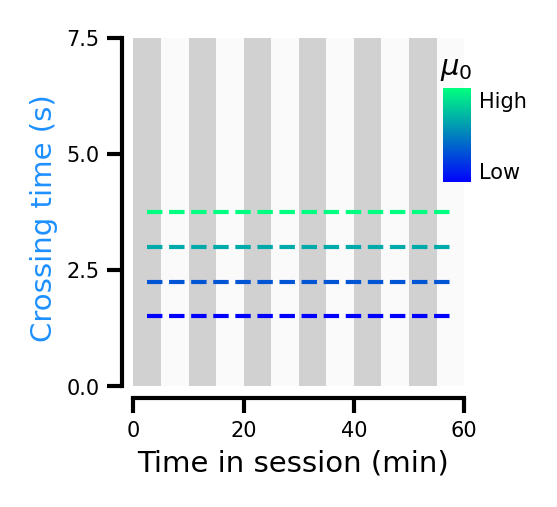

In [114]:
# plot variable median/mean fir each block
def Figure2A(ax=None):
    if ax is None:
        ax = plt.gca()

    rewardProbaBlock = [90, 10, 90, 10, 90, 10, 90, 10, 90, 10, 90, 10]
    blocks =  [[0, 300],  [300, 600],  [600, 900],  [900, 1200],
                [1200, 1500],  [1500, 1800],  [1800, 2100],  [2100, 2400],
                [2400, 2700],  [2700, 3000],  [3000, 3300],  [3300, 3600]]

    dummy_data = [2.25, 2.25, 2.25, 2.25, 2.25, 2.25, 2.25, 2.25, 2.25, 2.25, 2.25, 2.25]
    modifs = [-0.75, 0, 0.75, 1.5]
    
    cmap = plt.get_cmap('winter', len(modifs))
    for idx, modif in enumerate(modifs):
        ax.plot([(blocks[i][1] + blocks[i][0])/120 for i in range(0, len(blocks))], 
                [dummy_data[i] + modif for i in range(0, len(blocks))],
                color=cmap(idx), ls='--')

    for i in range(0, len(blocks)):
        ax.axvspan(blocks[i][0]/60, blocks[i][1]/60, ymin=1/30, ymax=1, color='grey', alpha=rewardProbaBlock[i]/250, lw=0)
    
    ax.set_xlabel("Time in session (min)")
    ax.set_ylabel("Crossing time (s)", color='dodgerblue')
    ax.set_xlim(-2, 60)
    ax.set_ylim(-.25, 7.5)
    ax.set_yticks([0, 2.5, 5, 7.5])

    ax.spines['left'].set_bounds(0, 7.5)
    ax.spines['bottom'].set_bounds(0, 60) 

fig, ax = plt.subplots(1, 1, figsize=(cm2inch(4), cm2inch(4)))
Figure2A(ax=ax)


l, b, h, w = 0.9, .65, 0.2, 0.06
ax1 = fig.add_axes([l, b, w, h])

def plot_colorbar(ax=None, label='label', y=1.35, labelpad=-17, show_zero=False):
    ax.xaxis.set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    N = 4
    c = np.arange(1, 100*N + 1)
    cmap_ = plt.get_cmap('winter', 100*N)
    dummie_ax = ax.scatter(c, c, c=c, cmap=cmap_)
    ax.cla()


    shift = 50
    if show_zero:
        cb=fig.colorbar(dummie_ax, cax=ax, ticks=[np.min(c)+shift, 150, np.max(c)-shift])
        cb.ax.set_yticklabels(['Low', '0', 'High'], rotation=0, fontsize=5)
        ax.axhline(150, color='k', lw=0.5, ls='--')

    else:
        cb=fig.colorbar(dummie_ax, cax=ax, ticks=[np.min(c)+shift, np.max(c)-shift])
        cb.ax.set_yticklabels(['Low', 'High'], rotation=0, fontsize=5)


    cb.outline.set_edgecolor(None)
    cb.set_label(label, labelpad=labelpad,y=y, rotation=0, fontsize=7)
    cb.ax.yaxis.set_tick_params(size=0)


plot_colorbar(ax=ax1, label=r'$\mu_0$')

# 2B $\mu_t$

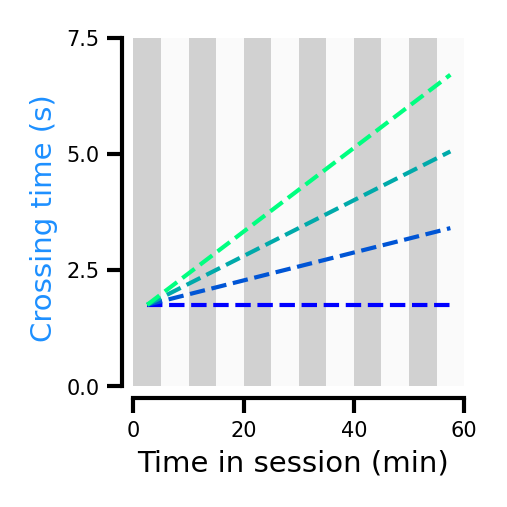

In [115]:
# plot variable median/mean fir each block
def Figure2B(ax=None):

    if ax is None:
        ax = plt.gca()

    rewardProbaBlock = [90, 10, 90, 10, 90, 10, 90, 10, 90, 10, 90, 10]
    blocks =  [[0, 300],  [300, 600],  [600, 900],  [900, 1200],
                [1200, 1500],  [1500, 1800],  [1800, 2100],  [2100, 2400],
                [2400, 2700],  [2700, 3000],  [3000, 3300],  [3300, 3600]]

    dummy_data = [1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.75]
    modifs = [0, 0.15, .3, .45]
    cmap = plt.get_cmap('winter', len(modifs))
    
    for idx, modif in enumerate(modifs):
        ax.plot([(blocks[i][1] + blocks[i][0])/120 for i in range(0, len(blocks))], 
                [dummy_data[i] + (i*modif) for i in range(0, len(blocks))],
                color=cmap(idx), ls='--')

    for i in range(0, len(blocks)):
        ax.axvspan(blocks[i][0]/60, blocks[i][1]/60, ymin=1/30, ymax=1, color='grey', alpha=rewardProbaBlock[i]/250, lw=0)
    
    ax.set_xlabel("Time in session (min)")
    ax.set_ylabel("Crossing time (s)", color='dodgerblue')
    ax.set_xlim(-2, 60)
    ax.set_ylim(-.25, 7.5)
    ax.set_yticks([0, 2.5, 5, 7.5])

    ax.spines['left'].set_bounds(0, 7.5)
    ax.spines['bottom'].set_bounds(0, 60)


fig, ax = plt.subplots(1, 1, figsize=(cm2inch(4), cm2inch(4)))
Figure2B(ax=ax)

# 2C $\mu_R$

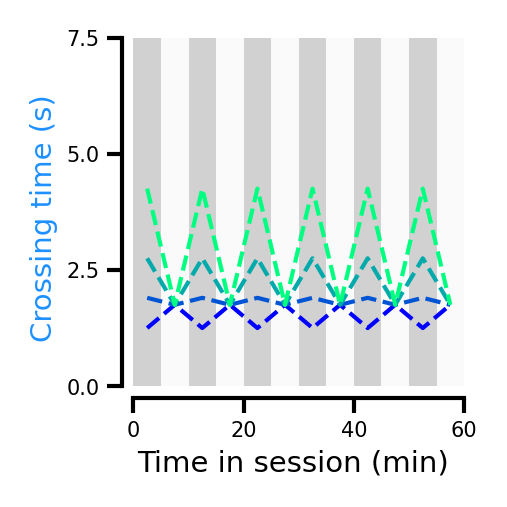

In [116]:
# plot variable median/mean fir each block
def Figure2C(ax=None):

    if ax is None:
        ax = plt.gca()

    rewardProbaBlock = [90, 10, 90, 10, 90, 10, 90, 10, 90, 10, 90, 10]
    blocks =  [[0, 300],  [300, 600],  [600, 900],  [900, 1200],
                [1200, 1500],  [1500, 1800],  [1800, 2100],  [2100, 2400],
                [2400, 2700],  [2700, 3000],  [3000, 3300],  [3300, 3600]]

    # dummy_data = [1.75, 2.7, 1.75, 2.75, 1.75, 2.75, 1.75, 2.7, 1.75, 2.75, 1.75, 2.80]

    dummy_data = [1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.75]
    modifs = [-.5, .15, 1, 2.5]
    cmap = plt.get_cmap('winter', len(modifs))

    for idx, modif in enumerate(modifs):
        
        ax.plot([(blocks[i][1] + blocks[i][0])/120 for i in range(0, len(blocks))], 
                [dummy_data[i] + modif if i % 2 == 0 else dummy_data[i] for i in range(0, len(blocks)) ],
                color=cmap(idx), ls='--')

    
    dummy_data = [1.25, 1.7, 1.2, 1.75, 1.2, 1.75, 1.25, 1.7, 1.30, 1.75, 1.25, 1.80]
 
    
    dummy_data = [1.25, 4.2, 1.2, 4.25, 1.2, 4.25, 1.25, 4.2, 1.30, 4.25, 1.25, 4.30] 


    for i in range(0, len(blocks)):
        ax.axvspan(blocks[i][0]/60, blocks[i][1]/60, ymin=1/30, ymax=1, color='grey', alpha=rewardProbaBlock[i]/250, lw=0)

    ax.set_xlabel("Time in session (min)")
    ax.set_ylabel("Crossing time (s)", color='dodgerblue')
    ax.set_xlim(-2, 60)
    ax.set_ylim(-.25, 7.5)
    ax.set_yticks([0, 2.5, 5, 7.5])

    ax.spines['left'].set_bounds(0, 7.5)
    ax.spines['bottom'].set_bounds(0, 60)

fig, ax = plt.subplots(1, 1, figsize=(cm2inch(4), cm2inch(4)))
Figure2C(ax=ax)

# 2D model + data

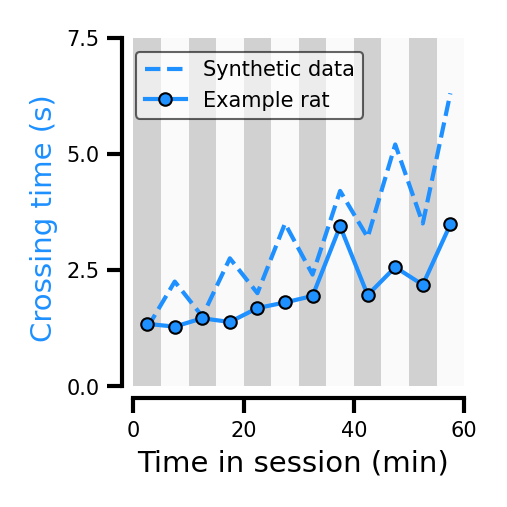

In [117]:
# plot variable median/mean fir each block
def Figure2D(ax=None):
    if ax is None:
        ax = plt.gca()

    rewardProbaBlock = [90, 10, 90, 10, 90, 10, 90, 10, 90, 10, 90, 10]
    blocks =  [[0, 300],  [300, 600],  [600, 900],  [900, 1200],
                [1200, 1500],  [1500, 1800],  [1800, 2100],  [2100, 2400],
                [2400, 2700],  [2700, 3000],  [3000, 3300],  [3300, 3600]]

    dummy_data = [1.25, 2.25, 1.5, 2.75, 2, 3.5, 2.4, 4.2, 3.2, 5.2, 3.5, 6.3]
    ax.plot([(blocks[i][1] + blocks[i][0])/120 for i in range(0, len(blocks))], 
            [dummy_data[i] for i in range(0, len(blocks))],  # or use median
            # marker='o', ms=3, 
            color='dodgerblue', 
            zorder=4, markeredgecolor='k', markeredgewidth=0.5,
            ls='--', label='Synthetic data')
    
    for i in range(0, len(blocks)):
        ax.axvspan(blocks[i][0]/60, blocks[i][1]/60, ymin=1/30, ymax=1, color='grey', alpha=rewardProbaBlock[i]/250, lw=0)
    
    ax.set_xlabel("Time in session (min)")
    ax.set_ylabel("Crossing time (s)", color='dodgerblue')
    ax.set_xlim(-2, 60)
    ax.set_ylim(-.25, 7.5)
    ax.set_yticks([0, 2.5, 5, 7.5])
    ax.spines['left'].set_bounds(0, 7.5)
    ax.spines['bottom'].set_bounds(0, 60)


    # experimental rat data

    root = "/home/david/Desktop/ALLDATA"
    animal = 'RatF02'
    session = 'RatF02_2021_07_22_18_14_16' 

    _params = get_from_pickle(root, animal, session, name="params.p")
    blocks = _params['blocks']
    rewardProbaBlock = _params['rewardProbaBlock']
    example_runningTimeInLeftBin, example_runningTimeInRightBin = get_from_pickle(root, animal, session, name="timeRun.p")
    data = [example_runningTimeInLeftBin[i]+example_runningTimeInRightBin[i] for i in range(0, 12)]

    ax.plot([(blocks[i][1] + blocks[i][0])/120 for i in range(0, len(blocks))], 
            [np.median(data[i]) for i in range(0, len(blocks))],  # or use median
            marker='o', ms=3, color='dodgerblue', 
            zorder=4, markeredgecolor='k', markeredgewidth=0.5, alpha=1, label='Example rat')

    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique), loc='upper left', bbox_to_anchor=(0.01, 0.99), frameon=True, fontsize=5, markerscale=1, edgecolor='k', facecolor='w').get_frame().set_linewidth(.5)


fig, ax = plt.subplots(1, 1, figsize=(cm2inch(4), cm2inch(4)))
Figure2D(ax=ax)

# 2E schematic distance

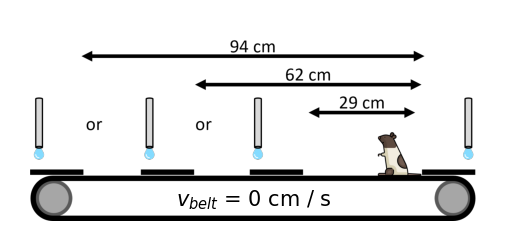

In [118]:
def Figure2E(ax=None, path=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    if path is None:
        path = "/home/david/Desktop/code/Figures/Fig2E.png"

    img = plt.imread(path)
    ax.imshow(img)
    ax.axis("off")
    ax.text(s=r'$v_{belt}$ = 0 cm / s', x=1745/2, y=666, ha="center", va="center", fontsize=5)

fig, ax = plt.subplots(1, 1, figsize=(cm2inch(4), cm2inch(4)))
Figure2E(ax=ax)

# 2FGH fit result dist

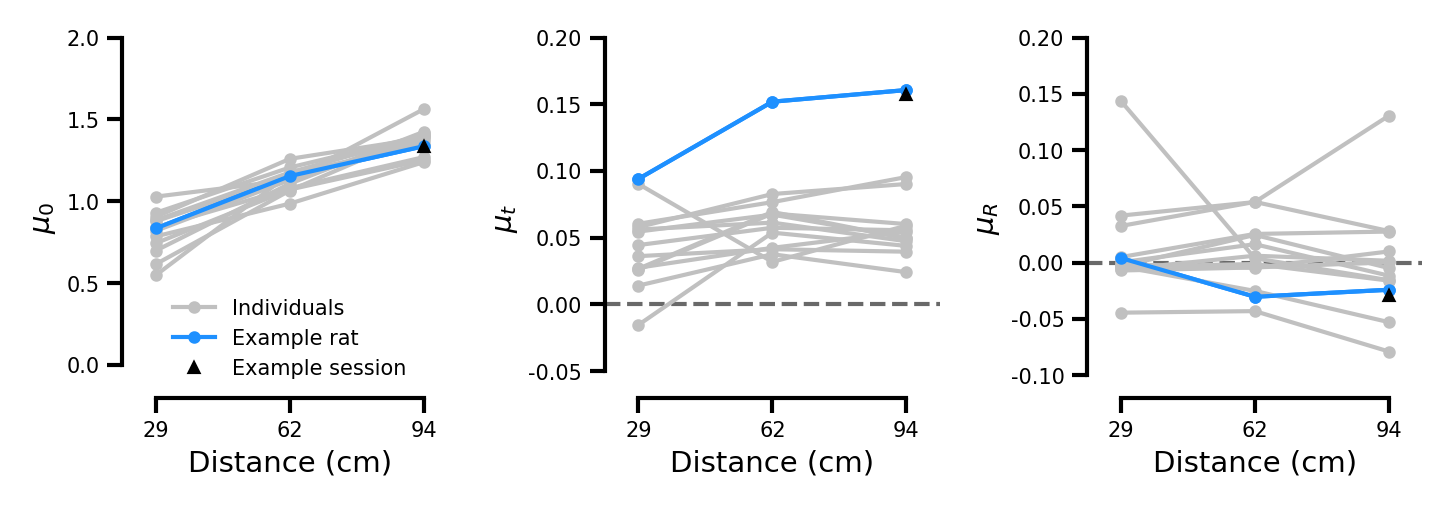

In [119]:
def Figure2F(ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    # ax.axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.5, zorder=0)

    _, _, _, _, _, _, mu_0, _, _, _, _, _ = pickle.load(open("picklejar/intact_lesionFITS.p", "rb"))

    for animal in animalList:
        ax.plot([0, 1, 2], [mu_0[animal]["60"], mu_0[animal]["90"], mu_0[animal]["120"]], 
                        color=rat_markers[animal][0], marker=rat_markers[animal][1], 
                        markersize=2, linestyle=lines[brainstatus[animal]], label='Individuals')
        
        if animal == 'RatF02':
            ax.plot([0, 1, 2], [mu_0[animal]["60"], mu_0[animal]["90"], mu_0[animal]["120"]], 
                        color=rat_markers[animal][0], marker=rat_markers[animal][1], 
                        markersize=2, linestyle=lines[brainstatus[animal]], zorder=5, label='Example rat')

    
    ex_mu, ex_mu_t, ex_mu_R, ex_sigma, ex_sigma_t, ex_sigma_R = pickle.load(open("picklejar/crossing_time_fit_example_session.p", "rb"))
    ax.plot(2, ex_mu, color='black', marker='^', zorder=10, markersize=2, linewidth=0, label='Example session')
    
    
    ax.set_xlim(-0.25, 2.25)
    ax.set_xticks([0, 1, 2])
    ax.set_xticklabels(["29", "62", "94"])
    ax.set_xlabel("Distance (cm)")

    ax.set_ylim(-.2, 2)
    ax.set_ylabel(r'$\mu_0$')
    ax.spines['left'].set_bounds(0, 2)
    ax.spines['bottom'].set_bounds(0, 2)

    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique), loc='lower center',# bbox_to_anchor=(0.01, 0.99), 
                                frameon=False, fontsize=5, markerscale=1, 
                                edgecolor='k', facecolor='w').get_frame().set_linewidth(.5)


def Figure2G(ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    _, _, _, _, _, _, _, mu_t, _, _, _, _ = pickle.load(open("picklejar/intact_lesionFITS.p", "rb"))

    for animal in animalList:
        ax.plot([0, 1, 2], [mu_t[animal]["60"], mu_t[animal]["90"], mu_t[animal]["120"]], 
                        color=rat_markers[animal][0], label=animal, marker=rat_markers[animal][1], 
                        markersize=2, linestyle=lines[brainstatus[animal]])

        if animal == 'RatF02':
            ax.plot([0, 1, 2], [mu_t[animal]["60"], mu_t[animal]["90"], mu_t[animal]["120"]], 
                            color=rat_markers[animal][0], label=animal, marker=rat_markers[animal][1], 
                            markersize=2, linestyle=lines[brainstatus[animal]], zorder=10)
    

    ex_mu, ex_mu_t, ex_mu_R, ex_sigma, ex_sigma_t, ex_sigma_R = pickle.load(open("picklejar/crossing_time_fit_example_session.p", "rb"))
    ax.plot(2, ex_mu_t, color='black', marker='^', zorder=10, markersize=2, linewidth=0)
    


    ax.set_xlim(-0.25, 2.25)
    ax.set_xticks([0, 1, 2])
    ax.set_xticklabels(["29", "62", "94"])
    ax.set_xlabel("Distance (cm)")

    ax.set_ylim(-.07, .2)
    ax.set_ylabel(r'$\mu_t$')
    ax.axhline(0, color='dimgray', linestyle='--', linewidth=1, alpha=1, zorder=0)

    ax.spines['left'].set_bounds(-0.05, 0.20)
    ax.spines['bottom'].set_bounds(0, 2)


def Figure2H(ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    _, _, _, _, _, _, _, _, mu_R, _, _, _ = pickle.load(open("picklejar/intact_lesionFITS.p", "rb"))

    for animal in animalList:
        ax.plot([0, 1, 2], [mu_R[animal]["60"], mu_R[animal]["90"], mu_R[animal]["120"]], 
                        color=rat_markers[animal][0], label=animal, marker=rat_markers[animal][1], 
                        markersize=2, linestyle=lines[brainstatus[animal]])
        
        if animal == 'RatF02':
            ax.plot([0, 1, 2], [mu_R[animal]["60"], mu_R[animal]["90"], mu_R[animal]["120"]], 
                        color=rat_markers[animal][0], label=animal, marker=rat_markers[animal][1], 
                        markersize=2, linestyle=lines[brainstatus[animal]], zorder=10)


    ex_mu, ex_mu_t, ex_mu_R, ex_sigma, ex_sigma_t, ex_sigma_R = pickle.load(open("picklejar/crossing_time_fit_example_session.p", "rb"))
    ax.plot(2, ex_mu_R, color='black', marker='^', zorder=10, markersize=2, linewidth=0)
    


    ax.set_xlim(-0.25, 2.25)
    ax.set_xticks([0, 1, 2])
    ax.set_xticklabels(["29", "62", "94"])
    ax.set_xlabel("Distance (cm)")

    ax.set_ylim(-.12, .2)
    ax.set_ylabel(r'$\mu_R$')
    ax.axhline(0, color='dimgray', linestyle='--', linewidth=1, alpha=1, zorder=0)

    ax.spines['left'].set_bounds(-0.1, 0.20)
    ax.spines['bottom'].set_bounds(0, 2)

fig, axs = plt.subplots(1, 3, figsize=(cm2inch(12), cm2inch(4)))
Figure2F(axs[0])
Figure2G(axs[1])
Figure2H(axs[2])

# 2I mean run speed Distance

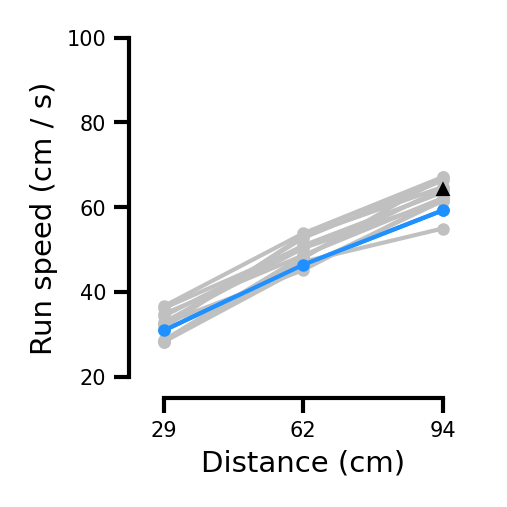

In [120]:
def Figure2I(ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    conds = ["60", "90", "120"]
    run_speeds = {k: {a: [] for a in animalList} for k in conds}

    for cond, sessionlist in zip(conds, [dist60, dist90, dist120]):
        for animal in animalList:
            for session in matchsession(animal, sessionlist):
                params = get_from_pickle(root, animal, session, name="params.p")
                for elem in sequence[animal, session]:
                    if sequence[animal, session][elem][1] == 'run':
                        tm_speed = params['treadmillSpeed'][get_block(sequence[animal, session][elem][0])]
                        run_speeds[cond][animal].append(abs(sequence[animal, session][elem][-1]) - tm_speed)


    for animal in animalList:
        ax.plot([0, 1, 2], [np.median(run_speeds[cond][animal]) for cond in conds], color=rat_markers[animal][0],
                marker=rat_markers[animal][1], markersize=2)

        if animal == "RatF02":
            ax.plot([0, 1, 2], [np.median(run_speeds[cond][animal]) for cond in conds], color=rat_markers[animal][0],
                    marker=rat_markers[animal][1], markersize=2, zorder=10)



    animal='RatF02'
    session='RatF02_2021_07_22_18_14_16'
    example_session_run_speeds = []
    params = get_from_pickle(root, animal, session, name="params.p")
    for elem in sequence[animal, session]:
        if sequence[animal, session][elem][1] == 'run':
            tm_speed = params['treadmillSpeed'][get_block(sequence[animal, session][elem][0])]
            example_session_run_speeds.append(abs(sequence[animal, session][elem][-1]) - tm_speed)

    ax.plot(2, np.median(example_session_run_speeds), color='black', marker='^', zorder=10, markersize=2, linewidth=0)

    ax.set_xlim(-0.25, 2.25)
    ax.set_xticks([0, 1, 2])
    ax.set_xticklabels(["29", "62", "94"])
    ax.set_xlabel("Distance (cm)")


    ax.set_ylim(15, 100)
    ax.set_yticks([20, 40, 60, 80, 100])
    ax.set_ylabel("Run speed (cm / s)")


    ax.spines['left'].set_bounds(20, 100)
    ax.spines['bottom'].set_bounds(0, 2)

fig, ax = plt.subplots(1, 1, figsize=(cm2inch(4), cm2inch(4)))
Figure2I(ax=ax)

# 2J schematic vbelt

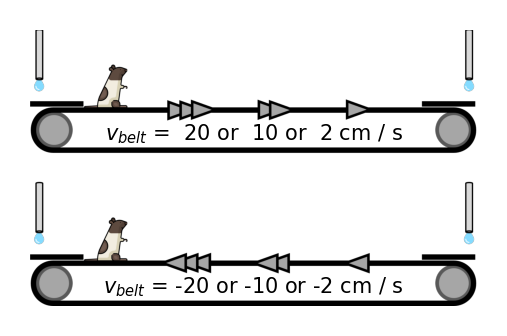

In [121]:
def Figure2J(ax=None, path=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    if path is None:
        path = "/home/david/Desktop/code/Figures/Fig2J.png"

    img = plt.imread(path)
    ax.imshow(img)
    ax.axis("off")
    ax.text(s=r'$v_{belt}$ =  20 or  10 or  2 cm / s', x=1745/2, y=405, ha="center", va="center", fontsize=5)
    ax.text(s=r'$v_{belt}$ = -20 or -10 or -2 cm / s', x=1745/2, y=1005, ha="center", va="center", fontsize=5)

fig, ax = plt.subplots(1, 1, figsize=(cm2inch(4), cm2inch(4)))
Figure2J(ax=ax)

# 2KLM fit results vbelt

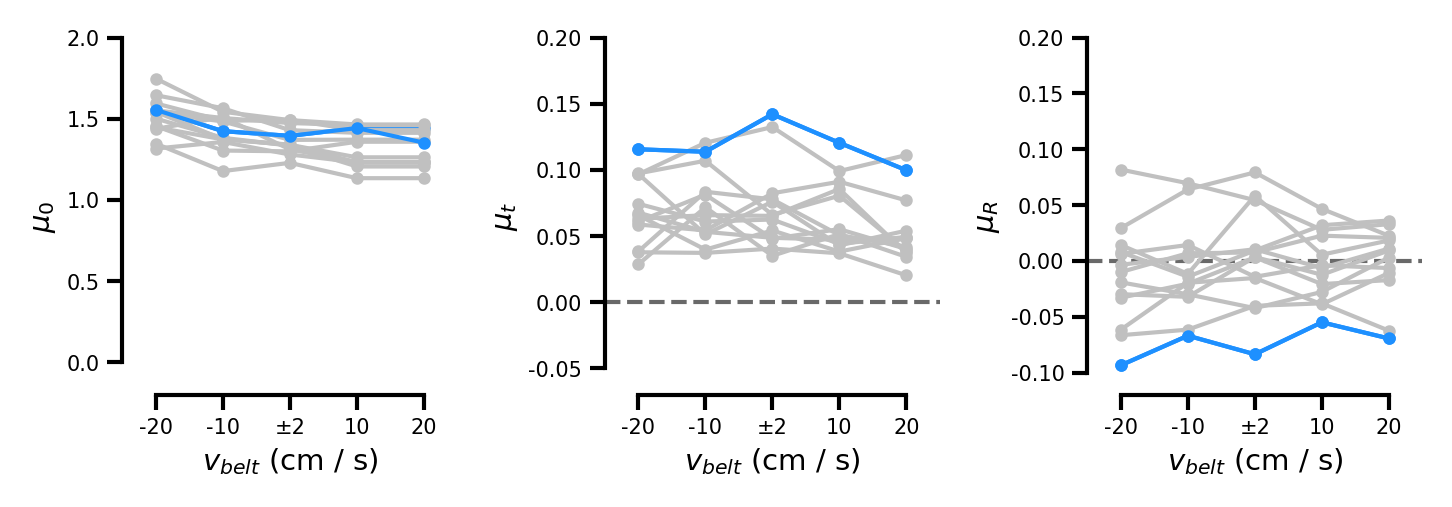

In [122]:
def Figure2K(ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    _, _, _, _, _, _, mu_0, _, _, _, _, _ = pickle.load(open("picklejar/intact_lesionFITS.p", "rb"))

    for animal in animalList:
        ax.plot([0, 1, 2, 3, 4], [mu_0[animal]["rev20"], mu_0[animal]["rev10"], mu_0[animal]["2"], mu_0[animal]["10"], mu_0[animal]["10"]], 
                        color=rat_markers[animal][0], label=animal, marker=rat_markers[animal][1], 
                        markersize=2, linestyle=lines[brainstatus[animal]])
    
        if animal == "RatF02":
            ax.plot([0, 1, 2, 3, 4], [mu_0[animal]["rev20"], mu_0[animal]["rev10"], mu_0[animal]["2"], mu_0[animal]["10"], mu_0[animal]["20"]], 
                        color=rat_markers[animal][0], label=animal, marker=rat_markers[animal][1], 
                        markersize=2, linestyle=lines[brainstatus[animal]], zorder=10)
    ax.set_xlim(-0.5, 4.5)
    ax.set_xticks([0, 1, 2, 3, 4])
    ax.set_xticklabels(["-20", "-10", "±2", "10", "20"])
    _ = r'$v_{belt}$'
    ax.set_xlabel(f'{_} (cm / s)')

    ax.set_ylim(-.2, 2)
    ax.set_ylabel(r'$\mu_0$')
    # ax.axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.5, zorder=0)

    ax.spines['left'].set_bounds(0, 2)
    ax.spines['bottom'].set_bounds(0, 4)


def Figure2L(ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    _, _, _, _, _, _, _, mu_t, _, _, _, _ = pickle.load(open("picklejar/intact_lesionFITS.p", "rb"))

    for animal in animalList:
        ax.plot([0, 1, 2, 3, 4], [mu_t[animal]["rev20"], mu_t[animal]["rev10"], mu_t[animal]["2"], mu_t[animal]["10"], mu_t[animal]["20"]], 
                        color=rat_markers[animal][0], label=animal, marker=rat_markers[animal][1], 
                        markersize=2, linestyle=lines[brainstatus[animal]])
        if animal == "RatF02":
            ax.plot([0, 1, 2, 3, 4], [mu_t[animal]["rev20"], mu_t[animal]["rev10"], mu_t[animal]["2"], mu_t[animal]["10"], mu_t[animal]["20"]], 
                        color=rat_markers[animal][0], label=animal, marker=rat_markers[animal][1], 
                        markersize=2, linestyle=lines[brainstatus[animal]], zorder=10)

    ax.set_xlim(-0.5, 4.5)
    ax.set_xticks([0, 1, 2, 3, 4])
    ax.set_xticklabels(["-20", "-10", "±2", "10", "20"])
    _ = r'$v_{belt}$'
    ax.set_xlabel(f'{_} (cm / s)')

    ax.set_ylim(-.07, .2)
    ax.set_ylabel(r'$\mu_t$')
    ax.axhline(0, color='dimgray', linestyle='--', linewidth=1, alpha=1, zorder=0)

    ax.spines['left'].set_bounds(-0.05, 0.20)
    ax.spines['bottom'].set_bounds(0, 4)

def Figure2M(ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    _, _, _, _, _, _, _, _, mu_R, _, _, _ = pickle.load(open("picklejar/intact_lesionFITS.p", "rb"))

    for animal in animalList:
        ax.plot([0, 1, 2, 3, 4], [mu_R[animal]["rev20"], mu_R[animal]["rev10"], mu_R[animal]["2"], mu_R[animal]["10"], mu_R[animal]["20"]], 
                        color=rat_markers[animal][0], label=animal, marker=rat_markers[animal][1], 
                        markersize=2, linestyle=lines[brainstatus[animal]])
        if animal == "RatF02":
            ax.plot([0, 1, 2, 3, 4], [mu_R[animal]["rev20"], mu_R[animal]["rev10"], mu_R[animal]["2"], mu_R[animal]["10"], mu_R[animal]["20"]], 
                        color=rat_markers[animal][0], label=animal, marker=rat_markers[animal][1], 
                        markersize=2, linestyle=lines[brainstatus[animal]], zorder=10)
    
    ax.set_xlim(-0.5, 4.5)
    ax.set_xticks([0, 1, 2, 3, 4])
    ax.set_xticklabels(["-20", "-10", "±2", "10", "20"])
    _ = r'$v_{belt}$'
    ax.set_xlabel(f'{_} (cm / s)')

    ax.set_ylim(-.12, .2)
    ax.set_ylabel(r'$\mu_R$')
    ax.axhline(0, color='dimgray', linestyle='--', linewidth=1, alpha=1, zorder=0)

    ax.spines['left'].set_bounds(-0.1, 0.20)
    ax.spines['bottom'].set_bounds(0, 4)

fig, axs = plt.subplots(1, 3, figsize=(cm2inch(12), cm2inch(4)))
Figure2K(axs[0])
Figure2L(axs[1])
Figure2M(axs[2])

# 2N mean run speed vbelt

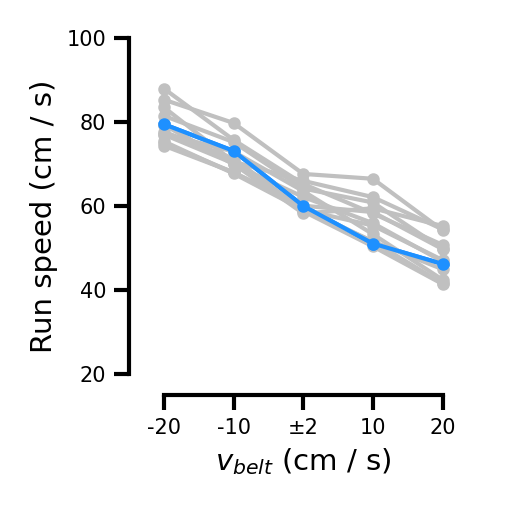

In [123]:
def Figure2N(ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    conds = ["TMrev20", "TMrev10", "TM2", "TM10", "TM20"]
    run_speeds = {k: {a: [] for a in animalList} for k in conds}

    for cond, sessionlist in zip(conds, [TMrev20, TMrev10, TM2, TM10, TM20]):
        for animal in animalList:
            for session in matchsession(animal, sessionlist):
                params = get_from_pickle(root, animal, session, name="params.p")
                for elem in sequence[animal, session]:
                    if sequence[animal, session][elem][1] == 'run':
                        tm_speed = params['treadmillSpeed'][get_block(sequence[animal, session][elem][0])]
                        run_speeds[cond][animal].append(abs(sequence[animal, session][elem][-1]) - tm_speed)


    for animal in animalList:
        ax.plot([0, 1, 2, 3, 4], [np.median(run_speeds[cond][animal]) for cond in conds], color=rat_markers[animal][0],
                marker=rat_markers[animal][1], markersize=2)
        if animal == 'RatF02':
            ax.plot([0, 1, 2, 3, 4], [np.median(run_speeds[cond][animal]) for cond in conds], color=rat_markers[animal][0],
                marker=rat_markers[animal][1], markersize=2, zorder=10)
                
    ax.set_xlim(-0.5, 4.5)
    ax.set_xticks([0, 1, 2, 3, 4])
    ax.set_xticklabels(["-20", "-10", "±2", "10", "20"])
    _ = r'$v_{belt}$'
    ax.set_xlabel(f'{_} (cm / s)')

    ax.set_ylim(15, 100)
    ax.set_yticks([20, 40, 60, 80, 100])
    ax.set_ylabel("Run speed (cm / s)")

    ax.spines['left'].set_bounds(20, 100)
    ax.spines['bottom'].set_bounds(0, 4)

fig, ax = plt.subplots(1, 1, figsize=(cm2inch(4), cm2inch(4)))
Figure2N(ax=ax)

# Figure 2

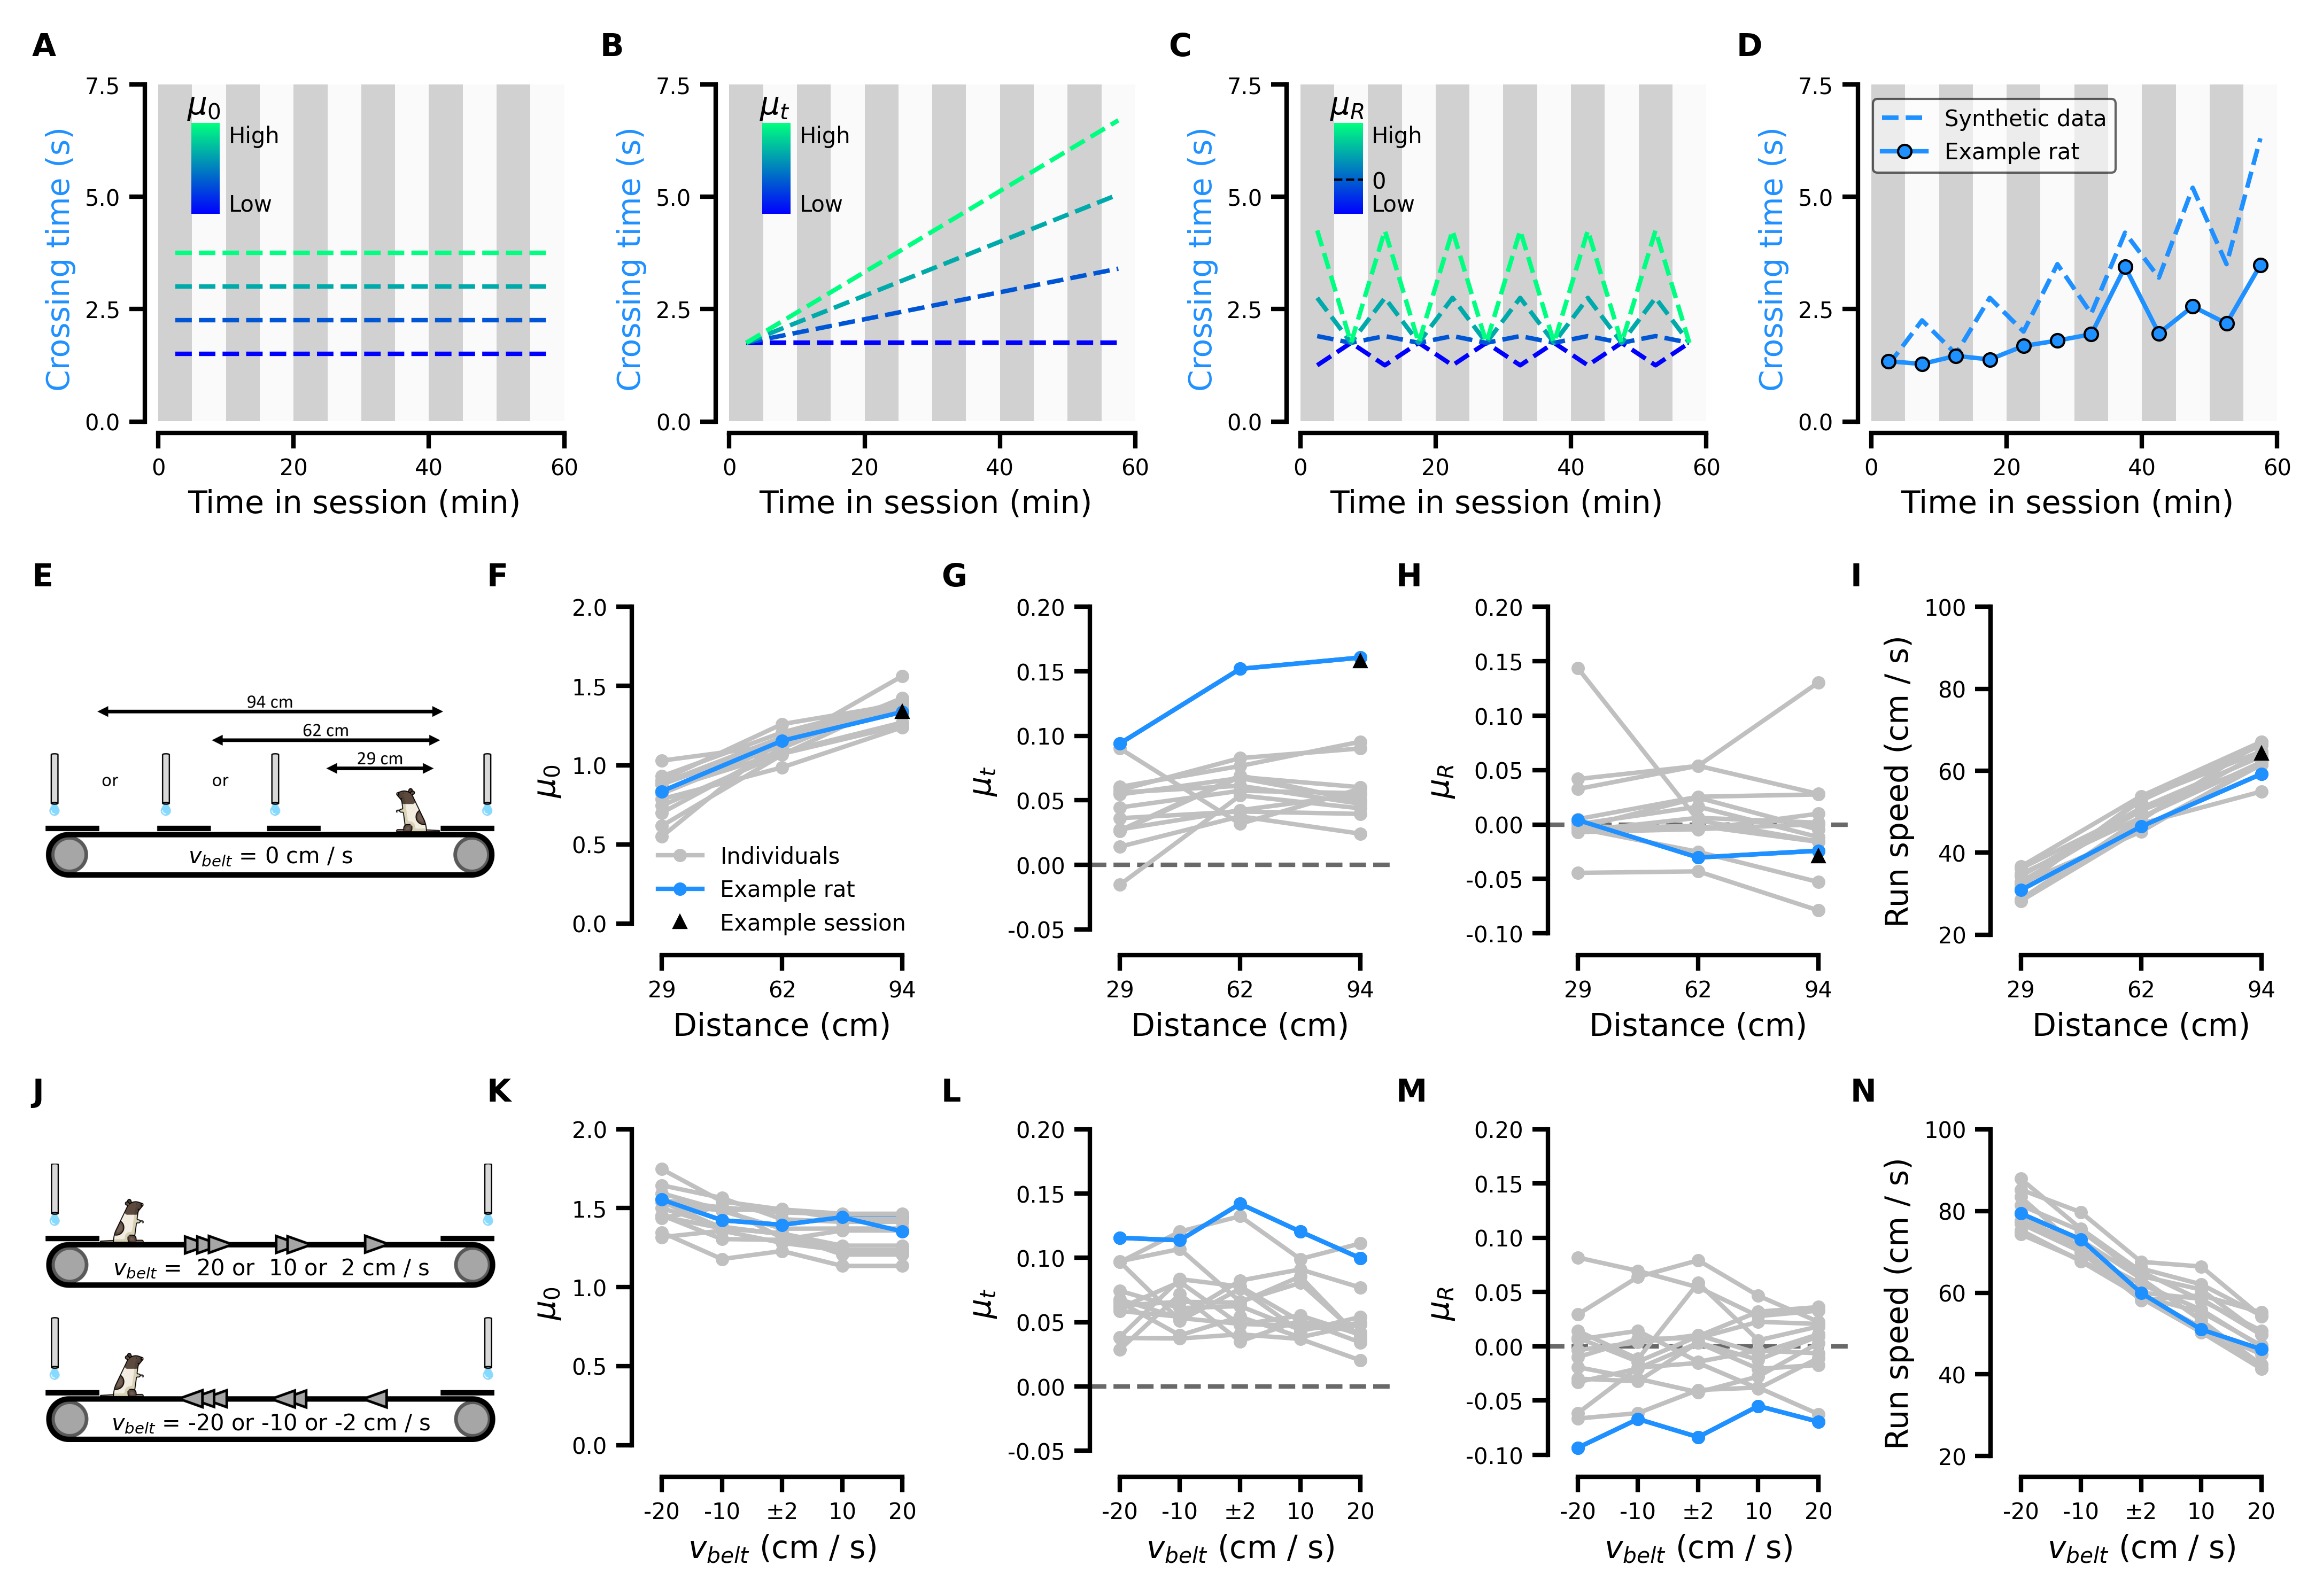

In [132]:

fig = plt.figure(figsize=(cm2inch(18), cm2inch(12)), constrained_layout=True, facecolor='w', dpi=600)

gs0 = fig.add_gridspec(5, 1, wspace=.5, hspace=.5, height_ratios=[9, 1, 9, 1, 9])

row1 = gs0[0].subgridspec(1, 4)
explanation_mu_0 = plt.subplot(row1[0, 0])
explanation_mu_t = plt.subplot(row1[0, 1])
explanation_mu_R = plt.subplot(row1[0, 2])
modeldata = plt.subplot(row1[0, 3])

row2 = gs0[2].subgridspec(1, 5, width_ratios=[3, 2, 2, 2, 2])
schematic_distances = plt.subplot(row2[0, 0])
fit_mu_0_distance = plt.subplot(row2[0, 1])
fit_mu_t_distance = plt.subplot(row2[0, 2])
fit_mu_R_distance = plt.subplot(row2[0, 3])
speed_distance = plt.subplot(row2[0, 4])

row3 = gs0[4].subgridspec(1, 5, width_ratios=[3, 2, 2, 2, 2])
schematic_vbelts = plt.subplot(row3[0, 0])
fit_mu_0_vbelt = plt.subplot(row3[0, 1])
fit_mu_t_vbelt = plt.subplot(row3[0, 2])
fit_mu_R_vbelt = plt.subplot(row3[0, 3])
speed_vbelt = plt.subplot(row3[0, 4])

figuresLabels={"A":[0.00, 1.00], "B":[0.25, 1.00], "C":[0.50, 1.00], "D":[0.75, 1.00],
               "E":[0.00, 0.65], "F":[0.20, 0.65], "G":[0.40, 0.65], "H":[0.60, 0.65], "I":[0.80, 0.65],
               "J":[0.00, 0.31], "K":[0.20, 0.31], "L":[0.40, 0.31], "M":[0.60, 0.31], "N":[0.80, 0.31]}

for label,coordinates in sorted(figuresLabels.items()):
    fig.text(coordinates[0], coordinates[1],
             label, figure=fig, 
             weight='bold', fontsize=7, ha='left', va='bottom')

Figure2A(ax=explanation_mu_0)
Figure2B(ax=explanation_mu_t)
Figure2C(ax=explanation_mu_R)
Figure2D(ax=modeldata)

Figure2E(ax=schematic_distances)
Figure2F(ax=fit_mu_0_distance)
Figure2G(ax=fit_mu_t_distance)
Figure2H(ax=fit_mu_R_distance)
Figure2I(ax=speed_distance)

Figure2J(ax=schematic_vbelts)
Figure2K(ax=fit_mu_0_vbelt)
Figure2L(ax=fit_mu_t_vbelt)
Figure2M(ax=fit_mu_R_vbelt)
Figure2N(ax=speed_vbelt)


h, w = 0.06, 0.0125

cbarA = fig.add_axes([.07, .9, w, h])
plot_colorbar(ax=cbarA, label=r'$\mu_0$')

cbarB = fig.add_axes([.3212, .9, w, h])
plot_colorbar(ax=cbarB, label=r'$\mu_t$')

cbarC = fig.add_axes([.573, .9, w, h])
plot_colorbar(ax=cbarC, label=r'$\mu_R$', show_zero=True)

plt.savefig("/home/david/Desktop/code/Figure_2.pdf", facecolor='w', 
        edgecolor='none', bbox_inches='tight', format="pdf", dpi=600)